In [1]:
# # 그래픽 카드 둘로 쓰기 (두개 있을때, 하나만 있다면 0)
# # gpu idx 를 0 또는 1 로 설정하시오
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(1) # gpu idx

In [2]:
# 경로에 폴더가 없으면 폴더 만들기
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [3]:
import wfdb.processing as wp
from tqdm import tqdm
import numpy as np
import itertools
import random
import wfdb

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

EPOCH = 200
KERNEL_SIZE = 3
POOLING_SIZE = 2
BATCH_SIZE = 128

DATA_PATH = "./pickle_rand/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

def zero_sum(x_array, y_array):
    x_return_array, y_return_array = [], []
    for i in range(len(x_array)):
        if np.sum(x_array[i]) == 0:
            continue
        else:
            x_return_array.append(x_array[i])
            y_return_array.append(y_array[i])
    return x_return_array, y_return_array

def flatter(list_of_list):
    flatList = [ item for elem in list_of_list for item in elem]
    return flatList

def TrainSetPadding(Xarray, Yarray):
    Xreturn, yreturn = [], []
    for i in range(len(Xarray)):
        beat_list = Xarray[i]
        beat_anno = Yarray[i]

        if np.sum(beat_list) == 0:
            continue

        if len(beat_list) >= 428:
            yreturn.append(beat_anno)
            Xreturn.append(beat_list[:428])
        
        else:
            random_front_add = np.random.randint(0, 428 - len(beat_list))
            random_back_add  = 428 - (random_front_add + len(beat_list))
            yreturn.append(beat_anno) 
            Xreturn.append(
                np.append([0.0], np.pad(beat_list, (random_front_add, random_back_add), 'constant', constant_values=0))[:428]
            )
        
    return np.array(Xreturn), np.array(yreturn)

def TestSetPadding(Xarray, Yarray):
    Xreturn, yreturn = [], []
    for i in range(len(Xarray)):
        beat_list = Xarray[i]
        beat_anno = Yarray[i]

        if np.sum(beat_list) == 0:
            continue

        if len(beat_list) > 428:
            yreturn.append(beat_anno)
            Xreturn.append(beat_list[:428])

        else:
            yreturn.append(beat_anno)
            cutting_off = int((428 - len(beat_list)) / 2)

            if len(np.pad(beat_list, cutting_off, 'constant', constant_values=0)) == 427:
                Xreturn.append(np.append([0.0], np.pad(beat_list, cutting_off, 'constant', constant_values=0)))

            else:
                Xreturn.append(np.pad(beat_list, cutting_off, 'constant', constant_values=0)[:428])
    return np.array(Xreturn), np.array(yreturn)    

def concater(normal, supra, ventri, fusion, q):
    return list(itertools.chain(normal, supra, ventri, fusion, q))


# 데이터 불러오기

In [4]:
# Cutting as a beat that just raw signal.
# That's it.

PICKLE_PATH = "./pickle_mat/"
DEFAULT_PATH = "./original_data/"
DB_PATH = ['mit']
EXTRA_NP = np.array(0)

NORAML_ANN = ['N', 'L', 'R', 'e', 'j']
SUPRA_ANN = ['A', 'a', 'J', 'S']
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

np.random.seed(42)

# - - - - - - - - - - - - - - - - - - - - - - - - - 
# Read only beats
R_PATH = DEFAULT_PATH + DB_PATH[0] + "/"

dict_ann = []
windowed_list = []
record_list = []
record_ann = []
longest = 0.

zero_padded_list = []

sigN, sigV, sigS, sigF, sigQ = [],[],[],[],[]
annN, annV, annS, annF, annQ = [],[],[],[],[]

# Read RECORDS txt file
print("[INFO] Read records file from ", R_PATH)
with open(R_PATH + 'RECORDS') as f:
    record_lines = f.readlines()

# Read Records
print("[INFO] Read RECORDS that what it read it")
for i in range(len(record_lines)):
    record_list.append(str(record_lines[i].strip()))

print("[INFO] Starting Cutting beat and make it shuffle as casino")
for j in tqdm(range(len(record_list))):
    temp_rpath = R_PATH + record_list[j]
    record_sg, _ = wfdb.rdsamp(temp_rpath, channels=[0], sampfrom=0)
    
    # Got R-R Peak by rdann funciton
    record_ann = list(wfdb.rdann(temp_rpath, 'atr', sampfrom=0).sample)[1:]
    record_ann_sym = list(wfdb.rdann(temp_rpath, 'atr', sampfrom=0).symbol)[1:]
    interval = wp.ann2rr(temp_rpath, 'atr', as_array=True)
    
    for i in range(len(record_ann)):            
        try:
            pre_add = record_ann[i - 1]
            post_add = record_ann[i + 1]
        except IndexError:
            pre_add = record_ann[i - 1]
            post_add = record_ann[-1]

        check_ann = record_ann_sym[i]
        avg_div = (interval[i - 1] + interval[i]) / 2 
        
        cut_pre_add = record_ann[i] - int((record_ann[i] - pre_add) / 2)
        cut_post_add = record_ann[i] + int((post_add - record_ann[i]) / 2) 
        
        cutted_beat = flatter(record_sg[cut_pre_add:cut_post_add])

        if check_ann in NORAML_ANN:         # Normal
            record_ann_sym[i] = 0
            sigN.append(cutted_beat)
            annN.append(record_ann_sym[i])

        elif check_ann in SUPRA_ANN:        # Supra-Ventricular
            record_ann_sym[i] = 1
            sigS.append(cutted_beat)
            annS.append(record_ann_sym[i])

        elif check_ann in VENTRI_ANN:       # Ventricular
            record_ann_sym[i] = 2
            sigV.append(cutted_beat)
            annV.append(record_ann_sym[i])

        elif check_ann in FUSION_ANN:       # Fusion
            record_ann_sym[i] = 3
            sigF.append(cutted_beat)
            annF.append(record_ann_sym[i])

        elif check_ann in UNCLASS_ANN:      # Unknown
            record_ann_sym[i] = 4
            sigQ.append(cutted_beat)
            annQ.append(record_ann_sym[i])

        else:
            continue
        
    dict_ann.append(record_ann_sym[i])

sigN, annN = zero_sum(sigN, annN)
sigS, annS = zero_sum(sigS, annS)
sigV, annV = zero_sum(sigV, annV)
sigF, annF = zero_sum(sigF, annF)
sigQ, annQ = zero_sum(sigQ, annQ)

sigN_ran = random.sample(sigN, 10000)
annN_ran = random.sample(annN, 10000)
sigN_np = np.array(sigN_ran)
annN_np = np.array(annN_ran)

sigS_np = np.array(sigS)
annS_np = np.array(annS)

sigV_np = np.array(sigV)
annV_np = np.array(annV)

sigF_np = np.array(sigF)
annF_np = np.array(annF)

sigQ_np = np.array(sigQ)
annQ_np = np.array(annQ)

Xtr_N, Xte_N, Ytr_N, Yte_N = train_test_split(sigN_np, annN_np, test_size=0.3, random_state=42, shuffle=True)
Xtr_S, Xte_S, Ytr_S, Yte_S = train_test_split(sigS_np, annS_np, test_size=0.3, random_state=42, shuffle=True)
Xtr_V, Xte_V, Ytr_V, Yte_V = train_test_split(sigV_np, annV_np, test_size=0.3, random_state=42, shuffle=True)
Xtr_F, Xte_F, Ytr_F, Yte_F = train_test_split(sigF_np, annF_np, test_size=0.3, random_state=42, shuffle=True)
Xtr_Q, Xte_Q, Ytr_Q, Yte_Q = train_test_split(sigQ_np, annQ_np, test_size=0.3, random_state=42, shuffle=True)

# - - - - - - - - - - - - - - - - - - - - -
# Under-sampling
# - - - - - - - - - - - - - - - - - - - - -
sigN_ran = random.sample(sorted(Xtr_N), 7000)
annN_ran = random.sample(sorted(Ytr_N), 7000)
Xtr_N = np.array(sigN_ran)
Ytr_N = np.array(annN_ran)

# - - - - - - - - - - - - - - - - - - - - -
# Over-sampling
# - - - - - - - - - - - - - - - - - - - - -
sigV_ran = []
annV_ran = []
for sig in range(7000):
    sigV_ran.append(random.choice(Xtr_V))
    annV_ran.append(random.choice(Ytr_V))
Xtr_V = np.array(sigV_ran)
Ytr_V = np.array(annV_ran)

# - - - - - - - - - - - - - - - - - - - - -
sigS_ran = []
annS_ran = []
for sig in range(7000):
    sigS_ran.append(random.choice(Xtr_S))
    annS_ran.append(random.choice(Ytr_S))
Xtr_S = np.array(sigS_ran)
Ytr_S = np.array(annS_ran)

# - - - - - - - - - - - - - - - - - - - - -
sigF_ran = []
annF_ran = []
for sig in range(7000):
    sigF_ran.append(random.choice(Xtr_F))
    annF_ran.append(random.choice(Ytr_F))
Xtr_F = np.array(sigF_ran)
Ytr_F = np.array(annF_ran)

# - - - - - - - - - - - - - - - - - - - - -
sigQ_ran = []
annQ_ran = []
for sig in range(7000):
    sigQ_ran.append(random.choice(Xtr_Q))
    annQ_ran.append(random.choice(Ytr_Q))
Xtr_Q = np.array(sigQ_ran)
Ytr_Q = np.array(annQ_ran)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

print("- "*35)

Xtr_N, Ytr_N = TrainSetPadding(Xtr_N, Ytr_N)
Xte_N, Yte_N = TestSetPadding(Xte_N, Yte_N)
print("[SIZE]\t\tXtr_N : {}\t\tXte_N : {}\n\t\tYtr_N : {}\t\t\tYte_N : {}".format(Xtr_N.shape, Xte_N.shape, Ytr_N.shape, Yte_N.shape))
print("- "*35)

Xtr_S, Ytr_S = TrainSetPadding(Xtr_S, Ytr_S)
Xte_S, Yte_S = TestSetPadding(Xte_S, Yte_S)
print("[SIZE]\t\tXtr_S : {}\t\tXte_S : {}\n\t\tYtr_S : {}\t\t\tYte_S : {}".format(Xtr_S.shape, Xte_S.shape, Ytr_S.shape, Yte_S.shape))
print("- "*35)

Xtr_V, Ytr_V = TrainSetPadding(Xtr_V, Ytr_V)
Xte_V, Yte_V = TestSetPadding(Xte_V, Yte_V)
print("[SIZE]\t\tXtr_V : {}\t\tXte_V : {}\n\t\tYtr_V : {}\t\t\tYte_V : {}".format(Xtr_V.shape, Xte_V.shape, Ytr_V.shape, Yte_V.shape))
print("- "*35)

Xtr_F, Ytr_F = TrainSetPadding(Xtr_F, Ytr_F)
Xte_F, Yte_F = TestSetPadding(Xte_F, Yte_F)
print("[SIZE]\t\tXtr_F : {}\t\tXte_F : {}\n\t\tYtr_F : {}\t\t\tYte_F : {}".format(Xtr_F.shape, Xte_F.shape, Ytr_F.shape, Yte_F.shape))
print("- "*35)

Xtr_Q, Ytr_Q = TrainSetPadding(Xtr_Q, Ytr_Q)
Xte_Q, Yte_Q = TestSetPadding(Xte_Q, Yte_Q)
print("[SIZE]\t\tXtr_Q : {}\t\tXte_Q : {}\n\t\tYtr_Q : {}\t\t\tYte_Q : {}".format(Xtr_Q.shape, Xte_Q.shape, Ytr_Q.shape, Yte_Q.shape))
print("- "*35 + "\n")

print("- "*10 + "Final Train-Test split result " + "- "*10)
X_train = np.array(concater(Xtr_N, Xtr_S, Xtr_V, Xtr_F, Xtr_Q))
y_train = np.array(concater(Ytr_N, Ytr_S, Ytr_V, Ytr_F, Ytr_Q))
X_test  = np.array(concater(Xte_N, Xte_S, Xte_V, Xte_F, Xte_Q))
y_test  = np.array(concater(Yte_N, Yte_S, Yte_V, Yte_F, Yte_Q))
print("[SIZE]\t\tX_train : {}\t\t\tX_test : {}\n\t\ty_train : {}\t\t\ty_test : {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print("- "*35)


[INFO] Read records file from  ./original_data/mit/
[INFO] Read RECORDS that what it read it
[INFO] Starting Cutting beat and make it shuffle as casino


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]
C:\Users\user\AppData\Local\Temp\ipykernel_8736\3135822481.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sigN_np = np.array(sigN_ran)
C:\Users\user\AppData\Local\Temp\ipykernel_8736\3135822481.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sigS_np = np.array(sigS)
C:\Users\user\AppData\Local\Temp\ipykernel_8736\3135822481.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
[SIZE]		Xtr_N : (7000, 428)		Xte_N : (3000, 428)
		Ytr_N : (7000,)			Yte_N : (3000,)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
[SIZE]		Xtr_S : (7000, 428)		Xte_S : (835, 428)
		Ytr_S : (7000,)			Yte_S : (835,)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
[SIZE]		Xtr_V : (7000, 428)		Xte_V : (2171, 428)
		Ytr_V : (7000,)			Yte_V : (2171,)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
[SIZE]		Xtr_F : (7000, 428)		Xte_F : (241, 428)
		Ytr_F : (7000,)			Yte_F : (241,)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
[SIZE]		Xtr_Q : (7000, 428)		Xte_Q : (2412, 428)
		Ytr_Q : (7000,)			Yte_Q : (2412,)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - - - - - - - - - Final Train-Test split result - - - - - - - - - - 
[SIZE]		X_train : (35000, 428)			X_test : (8659, 428)
		y_train : (35000,)			y_te

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True )

npx = np.array(X_train)
npy = np.array(y_train)
npx_vali = np.array(X_val)
npy_vali = np.array(y_val)
npx_test = np.array(X_test)
npy_test = np.array(y_test)

print("[SIZE]\t\tNpX lenght : {}\n\t\tNpY length : {}".format(npx.shape, npy.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(npx_vali.shape, npy_vali.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(npx_test.shape, npy_test.shape))

[SIZE]		NpX lenght : (35000, 428)
		NpY length : (35000,)
[SIZE]		X_validation length : (2858, 428)
		y_validation length : (2858,)
[SIZE]		X_test length : (5801, 428)
		y_test length : (5801,)


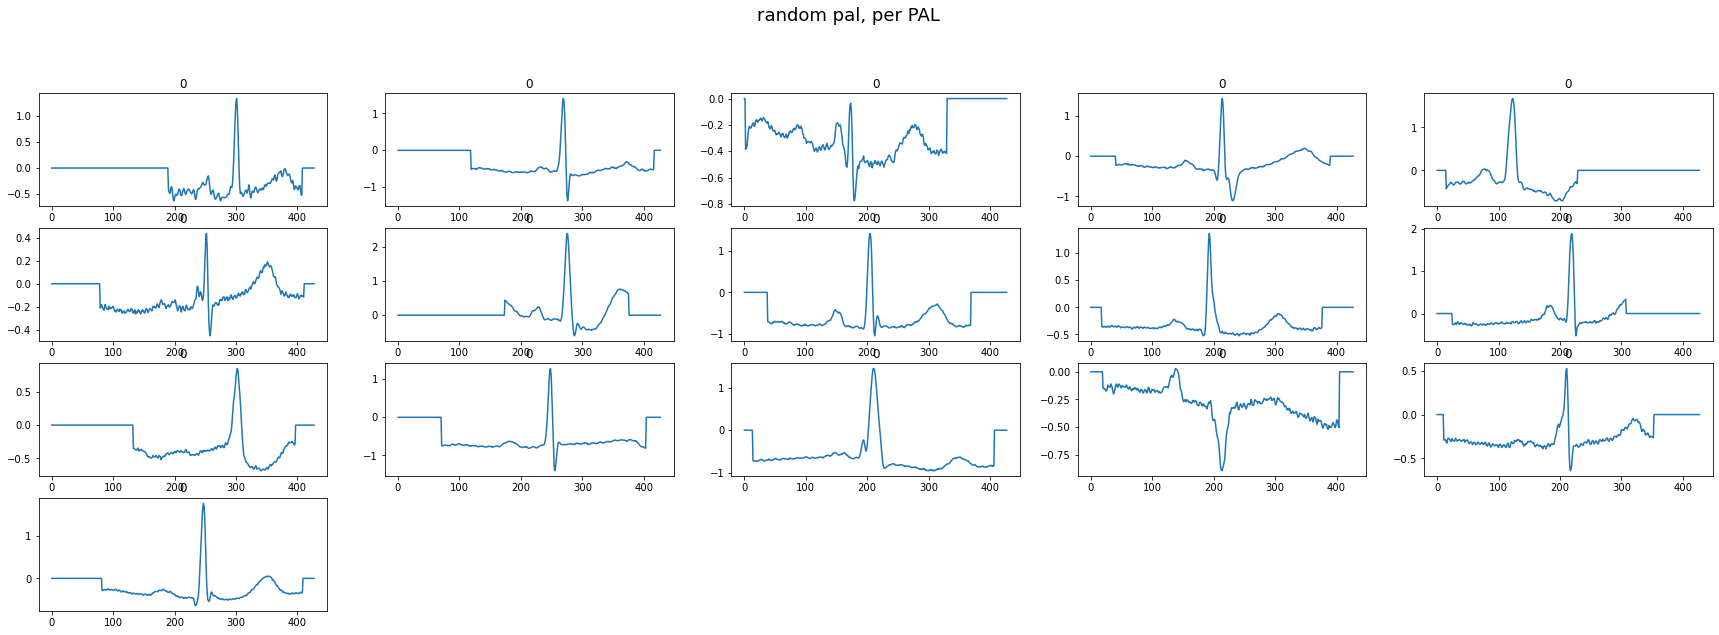

In [6]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

random.seed(42)

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.plot(npx[i])
    ax.set_title(str(npy[i]))
    n+=1

# 모델 생성

In [7]:
lefms = keras.Sequential([
    layers.Conv1D(32, 3, padding='same', input_shape=(428, 1)),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),

    layers.Conv1D(64, 3, padding='same'),
    layers.Conv1D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(64, 3, padding='same'),
    layers.Conv1D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(128, 3, padding='same'),
    layers.Conv1D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(128, 3, padding='same'),
    layers.Conv1D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(256, 3, padding='same'),
    layers.Conv1D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(256, 3, padding='same'),
    layers.Conv1D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),

    layers.Reshape((1, 1536)),
    layers.Dropout(0.5),
    layers.GRU(1536),
    layers.Dense(192, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [8]:
lefms.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 428, 32)           128       
                                                                 
 batch_normalization (BatchN  (None, 428, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 428, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 428, 64)           6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 428, 64)           12352     
                                                                 
 batch_normalization_1 (Batc  (None, 428, 64)          256       
 hNormalization)                                        

In [9]:
lefms.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

# train, test, validation data 나누기

In [10]:
# Train
X_train = tf.convert_to_tensor(npx)
X_train = tf.reshape(X_train, [-1, 428, 1])

y_train = tf.convert_to_tensor(npy)
y_train = tf.one_hot(y_train, 5)
y_train = tf.reshape(y_train, [-1, 5])
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)

# Validation
X_vali = tf.convert_to_tensor(npx_vali)
X_vali = tf.reshape(X_vali, [-1, 428, 1])

y_vali = tf.convert_to_tensor(npy_vali)
y_vali = tf.one_hot(y_vali, 5)
y_vali = tf.reshape(y_vali, [-1, 5])


print("X_validation shape : ", X_vali.shape)
print("y_validation shape : ", y_vali.shape)

# Test
X_test = tf.convert_to_tensor(npx_test)
X_test = tf.reshape(X_test, [-1, 428, 1])

y_test = tf.convert_to_tensor(npy_test)
y_test = tf.one_hot(y_test, 5)
y_test = tf.reshape(y_test, [-1, 5])
print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (35000, 428, 1)
y_train shape :  (35000, 5)
X_validation shape :  (2858, 428, 1)
y_validation shape :  (2858, 5)
X_test shape :  (5801, 428, 1)
y_test shape :  (5801, 5)


### 콜백 설정

In [11]:
# 콜백 설정
from keras.callbacks import EarlyStopping, ModelCheckpoint

outDir = './cheakpoint/random_lefms_model/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'
def get_callbacks(patience = 50):
    
    earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
  
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)
  
    # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
    callbacks = [model_checkpoint]

    return callbacks

# 학습하기

In [12]:
callbacks = get_callbacks()

lefms_hist = lefms.fit(X_train,
                       y_train,
                       batch_size=BATCH_SIZE, 
                       epochs=EPOCH, 
                       validation_data=(X_vali, y_vali),
                       callbacks = [callbacks])

Epoch 1/200
274/274 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8481
Epoch 1: val_accuracy improved from -inf to 0.34150, saving model to ./cheakpoint/random_lefms_model\weights-0.3415.h5
274/274 [==============================] - 26s 57ms/step - loss: 0.4253 - accuracy: 0.8481 - val_loss: 3.3428 - val_accuracy: 0.3415
Epoch 2/200
273/274 [============================>.] - ETA: 0s - loss: 0.2080 - accuracy: 0.9312
Epoch 2: val_accuracy improved from 0.34150 to 0.90973, saving model to ./cheakpoint/random_lefms_model\weights-0.9097.h5
274/274 [==============================] - 12s 44ms/step - loss: 0.2078 - accuracy: 0.9313 - val_loss: 0.3125 - val_accuracy: 0.9097
Epoch 3/200
273/274 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9488
Epoch 3: val_accuracy did not improve from 0.90973
274/274 [==============================] - 11s 41ms/step - loss: 0.1525 - accuracy: 0.9488 - val_loss: 0.8627 - val_accuracy: 0.7820
Epoch 4/200
273/27

# 결과 시각화 하기

In [13]:
# 학습 된 모델의 학습 과정 시각화
import matplotlib.pyplot as plt
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

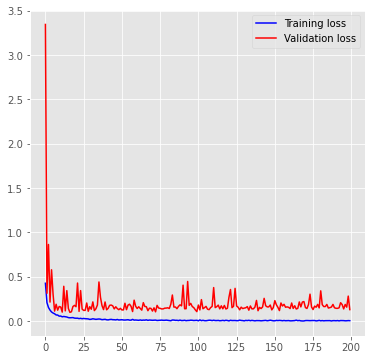

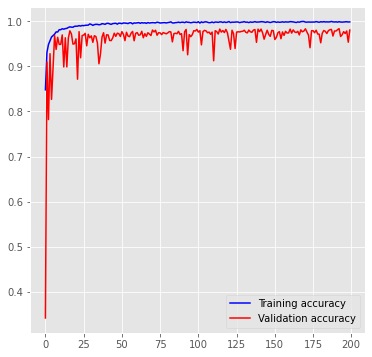

182/182 - 3s - loss: 0.1457 - accuracy: 0.9802 - 3s/epoch - 14ms/step
multi_model의 정확도: 98.02%
multi_model의 Loss: 0.14569677412509918


In [14]:
plot_model__hist(lefms_hist)
loss,acc = lefms.evaluate(X_test, y_test, verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# 모델 불러와서 confusion matrix 그리기

In [16]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/random_lefms_model/weights-0.9839.h5")

In [17]:
# 예측값 얻기
y_pred = reconstructed_model.predict(X_test)

182/182 [==============================] - 3s 10ms/step


In [18]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [19]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

In [20]:
# 최종 정확도 산출
score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

182/182 [==============================] - 3s 12ms/step - loss: 0.1463 - accuracy: 0.9822
정답률 =  0.9822444319725037 loss= 0.14633560180664062


### confusion matrix 그리기

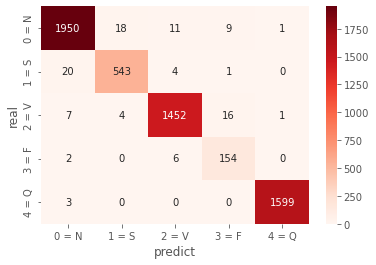

In [21]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

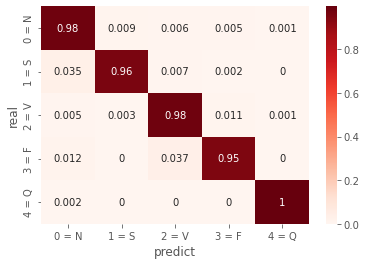

In [22]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

array([[1950,   18,   11,    9,    1],
       [  20,  543,    4,    1,    0],
       [   7,    4, 1452,   16,    1],
       [   2,    0,    6,  154,    0],
       [   3,    0,    0,    0, 1599]], dtype=int64)

In [24]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       0 = N       0.98      0.98      0.98      1989
       1 = S       0.96      0.96      0.96       568
       2 = V       0.99      0.98      0.98      1480
       3 = F       0.86      0.95      0.90       162
       4 = Q       1.00      1.00      1.00      1602

    accuracy                           0.98      5801
   macro avg       0.96      0.97      0.96      5801
weighted avg       0.98      0.98      0.98      5801

